# Flexible representation of quantum images - [FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf)

## Representation equation $| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \otimes | i \rangle$, where

$\theta_i$ - continuous representation of the inensity,

$i$ - binary expansion of the pixel coordinate.

Step 0: dependencies import

In [4]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math

Step 1: image generation

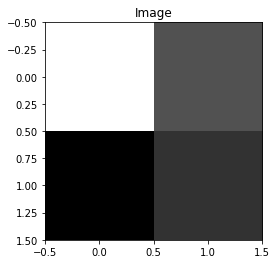

In [47]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

Step 2: flattening image into vector (for convenience). Calculation of sufficient nuber of qubits.

In [44]:
input_im = image.copy().flatten()
input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

Step 3: quantum circuit building.

In [45]:
color = QuantumRegister(1, 'color')
coordinate = QuantumRegister(coord_q_num, 'coordinate')
cr = ClassicalRegister(coord_q_num+1, 'c')
qc = QuantumCircuit(coordinate,color, cr)
qc.h(coordinate)
for i, pixel in enumerate(input_im):
    to_not = "{0:b}".format(i).zfill(2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    qc.cry(pixel,0,2)
    qc.cx(0,1)
    qc.cry(-pixel,1,2)
    qc.cx(0,1)
    qc.cry(pixel,1,2)
    if i!=len(input_im)-1:
        for j, bit in enumerate(to_not):
            if int(bit):
                qc.x(j)
        qc.barrier()
qc.swap(0,1)
qc.measure(list(range(qc.num_qubits)), list(range(cr.size)))

Metrics

| Image size  | Depth measure | # of utilized qubits
| ------------- | ------------- | -------------------|
| 2  | 26  | 3 |
| 4  | 107  | 5 |
| 8  | 431  | 7 |
| 16  | 1727  | 9 |
| 32  | 6911  | 11|
| 64  | 27647  | 13 |
| 128  | 110591  | 15 |
| 256  | 442367  | 17 |

In [46]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 26, # of qubits is 3


Circuit drawing

In [1]:
# qc.draw()

Step 4: quantum circuit execution, measurments' interpretation

In [22]:
def simulate(qc, input_im, shots=10000, print_data=True):    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    if print_data:
        print(counts)
        plot_histogram(counts)
        plt.show()
    nums = []
    for iter in range(len(input_im)):
        num = []
        for item in counts.items():
            if int(item[0][1:], 2)==iter:
                num.append((int(item[0][0], 2), item[1]))
        nums.append(num)
    colors = []
    for num in nums:
        if len(num)==2:
            if num[0][0] == 0:
                color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                colors.append(color)
            else:
                color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                colors.append(color)
        else:
            if num[0][0] == 0:
                colors.append(0)
            else:
                colors.append(np.pi/2)
    output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
    print(output_im, '\n', image.copy().flatten())
    return output_im

Input and measured images comparison

In [23]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im.reshape(2,2), cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im.reshape(2,2), cmap = 'gray')
    plt.title('real image')
    plt.show()

[ 13  57 158  47] 
 [ 14  55 160  51]


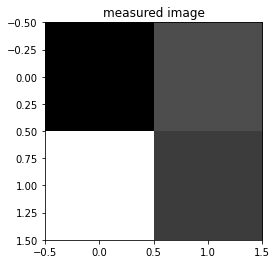

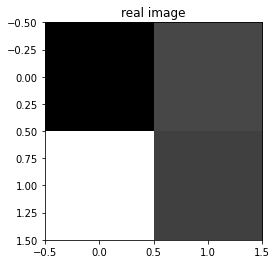

In [24]:
output_im = simulate(qc, input_im, print_data=False)
plot_to_compare(output_im, input_im)